In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import re
import random
plt.style.use('ggplot')
%matplotlib inline

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
english_stemmer=SnowballStemmer('english')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/Users/rajegupt/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda

Using TensorFlow backend.


In [3]:
# Pick randomly 20000 reviews

n = 413000  
s = 20000 
skip = sorted(random.sample(range(1,n),n-s))

df = pd.read_csv("Amazon_Unlocked_Mobile.csv", skiprows=skip)
#df = pd.read_csv("Amazon_Unlocked_Mobile.csv")

In [4]:
df.shape

(20840, 6)

In [5]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I originally was using the Samsung S2 Galaxy f...,0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Ordered this phone as a replacement for the sa...,1.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,Just... not good. The phone has great screen r...,0.0
4,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,5,Avianna LLC is an incredible seller. The phone...,0.0


In [6]:
data= df[['Reviews','Rating']]

In [7]:
data.isnull().any()

Reviews     True
Rating     False
dtype: bool

In [8]:
data.isnull().values.sum()

5

In [9]:
data = data[data['Reviews'].isnull()==False]

In [10]:
#df=df.dropna()
data.shape

(20835, 2)

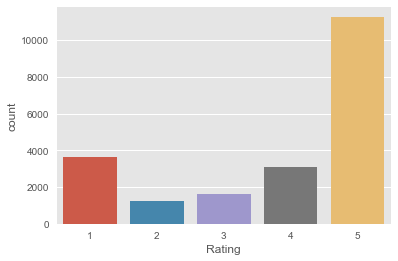

In [11]:
sns.countplot(data['Rating'])

In [12]:
print (data[data['Rating']==5].count())
print (data[data['Rating']<5].count())

Reviews    11276
Rating     11276
dtype: int64
Reviews    9559
Rating     9559
dtype: int64


In [13]:
def review_to_wordlist( review, remove_stopwords=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()

    #
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (True by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    b=[]
    stemmer = english_stemmer #PorterStemmer()
    for word in words:
        b.append(stemmer.stem(word))

    # 5. Return a list of words
    return(b)

In [14]:
train, test = train_test_split(data, test_size = 0.3)

In [15]:
# Clean all the reviews

clean_train_reviews = []
for review in train['Reviews']:
    clean_train_reviews.append( " ".join(review_to_wordlist(review)))
    
clean_test_reviews = []
for review in test['Reviews']:
    clean_test_reviews.append( " ".join(review_to_wordlist(review)))

/Users/rajegupt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/rajegupt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/Users/rajegupt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautifu

In [16]:
clean_train_reviews[0:5]

['happi razr maxx bought exact advertis written new phone got refurb chipper overal yes enjoy purchas',
 'might look previous generat phone g great phone ad bonus old phone come reason price clean googl experi fan lg launcher includ util seem hinder perform usabl happen oem phone samsung worst experi migrat tool use none one saw back googl reinstal applic fair straight forward updat drop devic got faulti display overse time facil return want local technician turn devic non origin screen devic sold new faulti display layer separ fix extra cost great phone happen',
 'heat issu',
 'excelent',
 'ok tks']

## TFidf Transformation

In [17]:
# use tfidf transformation with ngrams between 1 and 4.
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, max_features=200000,
                             ngram_range=(1,3), sublinear_tf=True)

vectorizer= vectorizer.fit(clean_train_reviews)
train_features= vectorizer.transform(clean_train_reviews)
test_features= vectorizer.transform(clean_test_reviews)

In [18]:
print (len(clean_train_reviews))
print (train_features.shape)
print ((clean_train_reviews[:1]))

14584
(14584, 61794)
['happi razr maxx bought exact advertis written new phone got refurb chipper overal yes enjoy purchas']


In [19]:
print (train_features)

  (0, 61618)	0.187350864929
  (0, 61404)	0.246391096352
  (0, 44251)	0.257381587474
  (0, 43233)	0.300555270899
  (0, 43232)	0.264670323223
  (0, 42250)	0.123391309707
  (0, 37623)	0.204811089337
  (0, 36535)	0.0541496695276
  (0, 35364)	0.161204765321
  (0, 32963)	0.29326653515
  (0, 32946)	0.157015480196
  (0, 32782)	0.112190562836
  (0, 30125)	0.29326653515
  (0, 22662)	0.138563884127
  (0, 21252)	0.122784753687
  (0, 15904)	0.251426256742
  (0, 15903)	0.166682245924
  (0, 14908)	0.300555270899
  (0, 14893)	0.18585454742
  (0, 5656)	0.300555270899
  (0, 5606)	0.117149137289
  (0, 654)	0.167367048512
  (1, 60916)	0.0764436711621
  (1, 60914)	0.0685421947587
  (1, 60903)	0.0484405180248
  :	:
  (14581, 2754)	0.125393634167
  (14581, 287)	0.163019644335
  (14582, 44569)	0.276856988669
  (14582, 44518)	0.159136272711
  (14582, 38226)	0.230142479903
  (14582, 36535)	0.0600484729814
  (14582, 34071)	0.165858818288
  (14582, 33173)	0.137599811174
  (14582, 32900)	0.325213575003
  (14582, 3

### Apply MLP on the TFidf Matrix

In [20]:
batch_size = 32
nb_classes = 5

In [21]:
X_train = train_features.toarray()
X_test = test_features.toarray()

print ('X_train_shape:', X_train.shape)
print ('X_test_shape:', X_test.shape)

X_train_shape: (14584, 61794)
X_test_shape: (6251, 61794)


In [22]:
y_train = np.array(train['Rating']-1)
y_test = np.array(test['Rating']-1)

# just like pd.get_dummies
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Y_train

array([[ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.]])

In [23]:
# pre-processing: divide by max and substract mean

scale = np.max(X_train)
mean = np.mean(X_train)

X_train = (X_train-mean)/scale
X_test = (X_test-mean)/scale

In [24]:
input_dim = X_train.shape[1]


In [29]:
# Here's a Deep Dumb MLP (DDMLP)

model = Sequential()
model.add(Dense(256, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# loss and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

print ('Training...')

model.fit(X_train, Y_train, nb_epoch=5, batch_size=16, validation_split=0.2)

print ("Generating Test Predictions...")
preds= model.predict_classes(X_test, verbose=0)


Training...


/Users/rajegupt/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 11667 samples, validate on 2917 samples
Epoch 1/5
11667/11667 [==============================] - 185s - loss: 1.0230 - val_loss: 0.8662

In [30]:
print ('Prediction accuracy', accuracy_score(test['Rating'],preds+1))

Prediction accuracy 0.694448888178
